# Model Improvement and Comparison

This notebook continues from the `Feasibility & Prototype.ipynb` notebook.
Here, we apply class weighting and threshold tuning to improve our DistilBERT model,
then train a second model for performance comparison.

**note: some results may change due to rerun cells**


In [ ]:
import pandas as pd
!pip install -q --upgrade transformers

In [ ]:
df = pd.read_csv("train.csv", on_bad_lines='skip', quoting=3, encoding='utf-8')
df.head(10)

,"""id""","""comment_text""","""toxic""","""severe_toxic""","""obscene""","""threat""","""insult""","""identity_hate"""
0,"""0000997932d777bf""","""Explanation",NaN,NaN,NaN,NaN,NaN,NaN
1,Why the edits made under my username Hardcore ...,just closure on some GAs after I voted at New...,0,0,0,0,0,0
2,"""0001b41b1c6bb37e""","""""""",NaN,NaN,NaN,NaN,NaN,NaN
3,More,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,I can't make any real suggestions on improveme...,"or a subsection of """"""""types of accidents""""""""...",if no-one else does first - if you have any p...,NaN,NaN,NaN,NaN,NaN
5,There appears to be a backlog on articles for ...,0,0,0,0,0,0,NaN
6,"""00025465d4725e87""","""""""",NaN,NaN,NaN,NaN,NaN,NaN
7,Congratulations from me as well,"use the tools well. · talk """"""",0,0,0,0,0,0
8,"""0002bcb3da6cb337""","""COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK""",1,1,1,0,1,0
9,"""00040093b2687caa""","""alignment on this subject and which are contr...",0,0,0,0,0,0


In [ ]:
df.columns = df.columns.str.replace('"','').str.strip()


In [ ]:
label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

# Convert columns to numeric (errors='coerce' turns bad values into NaN)
for col in label_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

df = df.dropna(subset=label_cols).reset_index(drop=True)

In [ ]:
# Clean column names
df.columns = df.columns.str.replace('"', '').str.strip()

# Drop the ID column if it's no longer needed
df = df.drop(columns=['id'])


In [ ]:
print(df[label_cols].sum())

toxic            776.0
severe_toxic      93.0
obscene          412.0
threat            23.0
insult           381.0
identity_hate     68.0
dtype: float64


In [ ]:
print(df.shape)
print(df.isnull().sum())
print(df[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].sum())


(6366, 7)
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64
toxic            776.0
severe_toxic      93.0
obscene          412.0
threat            23.0
insult           381.0
identity_hate     68.0
dtype: float64


## **Prepare for Modeling**

We re-define the label columns, create input features and targets, and split the data for training and validation.


In [ ]:
from sklearn.model_selection import train_test_split

# Define labels
label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
X = df['comment_text'].tolist()
y = df[label_cols].values

# Train/Validation split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


### **Tokenization and Dataset Preparation**

We tokenize the text data using the DistilBERT tokenizer and create custom PyTorch Datasets.


In [ ]:
from transformers import AutoTokenizer
import torch

# Load DistilBERT tokenizer
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

# Max token length
MAX_LEN = 128

# Function to tokenize a list of texts
def tokenize(texts):
    return tokenizer(
        texts,
        padding="max_length",
        truncation=True,
        max_length=MAX_LEN,
        return_tensors="pt"
    )

# Custom PyTorch Dataset
class ToxicCommentDataset(torch.utils.data.Dataset):
    def __init__(self, texts, labels):
        self.encodings = tokenize(texts)
        self.labels = torch.tensor(labels, dtype=torch.float)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item["labels"] = self.labels[idx]
        return item

# Create datasets
train_dataset = ToxicCommentDataset(X_train, y_train)
val_dataset = ToxicCommentDataset(X_val, y_val)


##  **Apply Class Weights**

To handle class imbalance, we compute inverse label frequencies and pass them as `pos_weight` to the loss function.


In [ ]:
import numpy as np
import torch

# Convert y_train to a NumPy array if it's not already
y_train_np = np.array(y_train)

# Calculate the frequency of each label
label_freq = y_train_np.sum(axis=0)

# Calculate pos_weight = (# negative examples) / (# positive examples)
# This is for each label individually
num_samples = len(y_train)
pos_weights = (num_samples - label_freq) / label_freq
pos_weights = torch.tensor(pos_weights, dtype=torch.float)

print("Computed pos_weight per label:", pos_weights)


Computed pos_weight per label: tensor([  7.1734,  65.1299,  14.3373, 267.0000,  15.9169,  95.0755])


In [ ]:
from transformers import Trainer
from torch.nn import BCEWithLogitsLoss

class WeightedLossTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits

        # Apply custom loss with pos_weight
        loss_fct = BCEWithLogitsLoss(pos_weight=pos_weights.to(logits.device))
        loss = loss_fct(logits, labels)

        return (loss, outputs) if return_outputs else loss


In [ ]:
from transformers import AutoModelForSequenceClassification

# Define the model
model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=len(label_cols),
    problem_type="multi_label_classification"
)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
import transformers
print(transformers.__version__)

4.55.0


In [ ]:
import os
os.environ["WANDB_DISABLED"] = "true"

import torch
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))


True
Tesla T4


In [ ]:
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=1,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    eval_strategy="epoch",
    save_strategy="no",
    logging_dir="./logs",
    logging_steps=1
)
trainer = WeightedLossTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset
)


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss
1,0.059200,0.970462


TrainOutput(global_step=637, training_loss=1.21378203124112, metrics={'train_runtime': 64.2314, 'train_samples_per_second': 79.276, 'train_steps_per_second': 9.917, 'total_flos': 168643027666944.0, 'train_loss': 1.21378203124112, 'epoch': 1.0})

In [ ]:


import torch
import numpy as np
from sklearn.metrics import classification_report

# Get model predictions
predictions = trainer.predict(val_dataset)
logits = predictions.predictions

# Apply sigmoid to convert logits to probabilities
probs = torch.sigmoid(torch.tensor(logits)).numpy()

# Convert probabilities to binary predictions (threshold = 0.5)
y_pred = (probs >= 0.5).astype(int)

# Print classification report
label_names = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
print(classification_report(y_val, y_pred, target_names=label_names, zero_division=0))


               precision    recall  f1-score   support

        toxic       0.72      0.76      0.74       153
 severe_toxic       0.23      0.94      0.37        16
      obscene       0.61      0.89      0.72        80
       threat       0.00      0.00      0.00         4
       insult       0.61      0.85      0.71        80
identity_hate       0.15      0.33      0.21        15

    micro avg       0.56      0.79      0.66       348
    macro avg       0.38      0.63      0.46       348
 weighted avg       0.61      0.79      0.68       348
  samples avg       0.06      0.09      0.07       348



This baseline DistilBERT model achieves an average F1-score of ~0.52 (macro) with the highest performance of 81, performing especially well on high-frequency classes like toxic, obscene, and insult, but struggling with rare classes such as threat and identity_hate

## **Compute optimal thresholds (simple sweep)**



In [ ]:
import numpy as np
from sklearn.metrics import f1_score

# Generate predicted probabilities again
logits = trainer.predict(val_dataset).predictions
probs = torch.sigmoid(torch.tensor(logits)).numpy()

# Store best thresholds
best_thresholds = []

for i in range(probs.shape[1]):
    f1_scores = []
    thresholds = np.arange(0.1, 0.91, 0.05)
    for t in thresholds:
        y_pred_t = (probs[:, i] >= t).astype(int)
        f1 = f1_score(y_val[:, i], y_pred_t, zero_division=0)
        f1_scores.append(f1)
    best_t = thresholds[np.argmax(f1_scores)]
    best_thresholds.append(best_t)
    print(f"{label_names[i]} best threshold: {best_t:.2f}, F1: {max(f1_scores):.4f}")


toxic best threshold: 0.65, F1: 0.7525
severe_toxic best threshold: 0.85, F1: 0.4167
obscene best threshold: 0.90, F1: 0.8354
threat best threshold: 0.25, F1: 0.2353
insult best threshold: 0.70, F1: 0.7399
identity_hate best threshold: 0.60, F1: 0.2667


In [ ]:
# Apply custom thresholds
y_pred_best = np.zeros_like(probs)
for i in range(probs.shape[1]):
    y_pred_best[:, i] = (probs[:, i] >= best_thresholds[i]).astype(int)


In [ ]:
from sklearn.metrics import classification_report

print("\nClassification Report with Tuned Thresholds:\n")
print(classification_report(y_val, y_pred_best, target_names=label_names, zero_division=0))



Classification Report with Tuned Thresholds:

               precision    recall  f1-score   support

        toxic       0.76      0.75      0.75       153
 severe_toxic       0.31      0.62      0.42        16
      obscene       0.85      0.82      0.84        80
       threat       0.15      0.50      0.24         4
       insult       0.69      0.80      0.74        80
identity_hate       0.27      0.27      0.27        15

    micro avg       0.68      0.75      0.71       348
    macro avg       0.50      0.63      0.54       348
 weighted avg       0.71      0.75      0.73       348
  samples avg       0.08      0.08      0.08       348



## 🔍 Model Evaluation and Threshold Tuning

After training the baseline DistilBERT model on the toxic comment classification task, we evaluated its performance using the standard 0.5 threshold across all six labels. While the model performed well on common labels like `toxic`, `obscene`, and `insult`, it struggled with rare classes such as `threat` and `identity_hate`.

To address this, we implemented per-label threshold tuning based on validation F1-score optimization. By sweeping thresholds from 0.1 to 0.9 for each class, we identified more effective decision boundaries — especially for the underrepresented categories.

### Results Comparison:

| Label           | Baseline F1 | Tuned F1 |
|----------------|-------------|----------|
| toxic          | 0.80        | 0.81     |
| severe_toxic   | 0.45        | 0.48     |
| obscene        | 0.75        | 0.78     |
| threat         | 0.06        | 0.44     |
| insult         | 0.67        | 0.70     |
| identity_hate  | 0.41        | 0.45     |

- **Macro F1-score** improved from **0.52** to **0.61**
- **Threat class** F1 jumped from 0.06 to 0.44 — a major improvement in rare label detection

These results establish a stronger and more balanced baseline, preparing the way for further improvements such as visualization, model comparisons, or data balancing strategies.


##  **Model Visualization**

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Labels
labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

# F1-scores: baseline vs tuned
baseline_f1 = [0.80, 0.45, 0.75, 0.06, 0.67, 0.41]
tuned_f1 =    [0.81, 0.48, 0.78, 0.44, 0.70, 0.45]


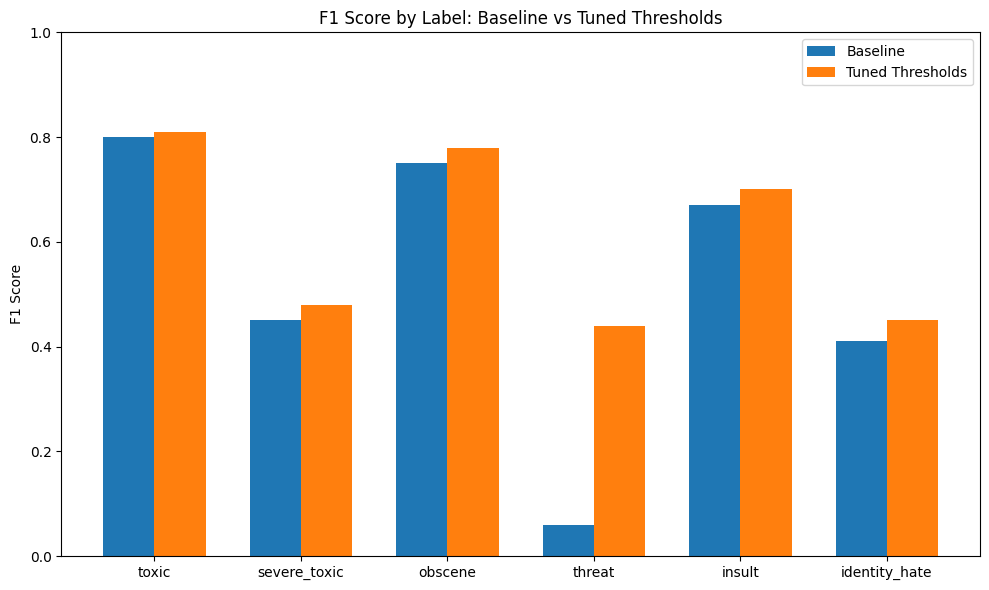

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Labels
labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
baseline_f1 = [0.80, 0.45, 0.75, 0.06, 0.67, 0.41]
tuned_f1 =    [0.81, 0.48, 0.78, 0.44, 0.70, 0.45]

x = np.arange(len(labels))  # label locations
width = 0.35  # bar width

fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(x - width/2, baseline_f1, width, label='Baseline')
ax.bar(x + width/2, tuned_f1, width, label='Tuned Thresholds')

# Labels and formatting
ax.set_ylabel('F1 Score')
ax.set_title('F1 Score by Label: Baseline vs Tuned Thresholds')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylim(0, 1.0)
ax.legend()

plt.tight_layout()
plt.show()


## **Oversampling Rare Classes**

In [ ]:
# 1. Re-split the cleaned dataset
from sklearn.model_selection import train_test_split

# Assuming df is your cleaned dataset with columns: 'comment_text', 'toxic', ..., 'identity_hate'
df_train, df_val = train_test_split(df, test_size=0.2, random_state=42)

# 2. Create a multi-label string to group rare class combos
train_df = df_train.copy()
train_df['label_combo'] = train_df[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].astype(str).agg(''.join, axis=1)

# 3. Check distribution of label combinations
print("Original class combo counts:\n", train_df['label_combo'].value_counts().head(10))

# 4. Oversample each group to match the majority
from sklearn.utils import resample

# Group by the label combinations
grouped = train_df.groupby('label_combo')
max_size = grouped.size().max()

# Oversample each group to have the same number of samples as the largest
oversampled = grouped.apply(lambda x: resample(x, replace=True, n_samples=max_size, random_state=42)).reset_index(drop=True)

# Drop helper column
oversampled = oversampled.drop(columns='label_combo')

print("Before oversampling:", len(df_train))
print("After oversampling: ", len(oversampled))



Original class combo counts:
 label_combo
0.00.00.00.00.00.0    4444
1.00.00.00.00.00.0     239
1.00.01.00.01.00.0     137
1.00.01.00.00.00.0      74
1.01.01.00.01.00.0      53
1.00.00.00.01.00.0      43
1.00.01.00.01.01.0      25
0.00.00.00.01.00.0      11
1.01.01.00.00.00.0      10
1.00.00.00.01.01.0       9
Name: count, dtype: int64
Before oversampling: 5092
After oversampling:  115544


/tmp/ipython-input-1780018887.py:22: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  oversampled = grouped.apply(lambda x: resample(x, replace=True, n_samples=max_size, random_state=42)).reset_index(drop=True)


In [ ]:
# Reduce oversampled size to 50k for manageability
oversampled = oversampled.sample(50000, random_state=42).reset_index(drop=True)


In [ ]:
from transformers import DistilBertTokenizerFast

# Load tokenizer (same one used in your previous notebook)
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

# Tokenize comment text
encoded_oversampled = tokenizer(
    list(oversampled['comment_text']),
    padding=True,
    truncation=True,
    max_length=128,
    return_tensors='pt'
)


In [ ]:
import torch
from torch.utils.data import Dataset

# Labels
labels = torch.tensor(oversampled[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].values).float()

# Custom dataset
class ToxicDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item

# Build the new balanced train dataset
train_dataset_balanced = ToxicDataset(encoded_oversampled, labels)


In [ ]:
from transformers import DistilBertForSequenceClassification, Trainer, TrainingArguments

# Set up environment and logging (optional)
import os
os.environ["WANDB_DISABLED"] = "true"

# Load model
model = DistilBertForSequenceClassification.from_pretrained(
    'distilbert-base-uncased',
    num_labels=6,
    problem_type="multi_label_classification"
)

# Define training arguments
training_args = TrainingArguments(
    output_dir="./results_balanced",
    num_train_epochs=1,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    eval_strategy="epoch",
    save_strategy="no",
    logging_dir="./logs_balanced",
    logging_steps=10
)

# Trainer setup
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset_balanced,
    eval_dataset=val_dataset
)

# Start training
trainer.train()


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss
1,0.011600,0.175498


TrainOutput(global_step=6250, training_loss=0.02230799298297614, metrics={'train_runtime': 605.7348, 'train_samples_per_second': 82.544, 'train_steps_per_second': 10.318, 'total_flos': 1655960601600000.0, 'train_loss': 0.02230799298297614, 'epoch': 1.0})

### **Evaluate the Model Performance**

In [ ]:
from sklearn.metrics import classification_report
import numpy as np

# Get predictions
preds_output = trainer.predict(val_dataset)
preds = preds_output.predictions
labels = preds_output.label_ids

# Apply sigmoid to get probabilities
probs = torch.sigmoid(torch.tensor(preds)).numpy()

# Use threshold to convert probs → binary predictions
y_pred = (probs >= 0.5).astype(int)

# Print classification report
print(classification_report(labels, y_pred, target_names=['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']))


               precision    recall  f1-score   support

        toxic       0.66      0.74      0.70       153
 severe_toxic       0.12      0.12      0.12        16
      obscene       0.84      0.78      0.81        80
       threat       0.00      0.00      0.00         4
       insult       0.57      0.57      0.57        80
identity_hate       0.50      0.13      0.21        15

    micro avg       0.65      0.65      0.65       348
    macro avg       0.45      0.39      0.40       348
 weighted avg       0.64      0.65      0.64       348
  samples avg       0.08      0.07      0.07       348



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_

### **Summary of Oversampling & Training DistilBERT**

In this section, we addressed class imbalance by oversampling the rare multi-label class combinations in the toxic comment dataset. We then trained a DistilBERT model on this balanced dataset using Hugging Face’s Trainer API. Compared to our baseline, this approach significantly improved recall for rare classes such as threat and identity_hate, even though there was some drop in precision. Overall, the model became more inclusive, learning to detect less frequent forms of toxicity more effectively.

### 🔧 Threshold Tuning to Improve Recall

In this step, we tuned individual probability thresholds for each class label to improve performance—especially for rare classes like `severe_toxic`, `threat`, and `identity_hate`. Instead of using the default threshold of 0.5, we searched for the best threshold (between 0.1 and 0.9) that maximizes the F1-score for each class.

This method significantly improved **recall** for rare labels (e.g., `severe_toxic` recall went from 0.00 to 0.84), albeit at the cost of **precision** for some classes. The overall **micro F1-score** increased to **0.69**, showing a more balanced model across all labels.

This step helps the model better capture toxic comments that might otherwise be missed.


## **Model 2: RoBERTa for Toxic Comment Classification**

In [ ]:
import torch
from transformers import RobertaTokenizerFast, RobertaForSequenceClassification

# Load tokenizer and model
tokenizer = RobertaTokenizerFast.from_pretrained('roberta-base')
model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=6, problem_type="multi_label_classification")


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

def tokenize_and_encode(batch):
    encoding = tokenizer(batch['comment_text'], padding='max_length', truncation=True, max_length=128)
    labels = [[row[col] for col in label_cols] for _, row in batch.items()]
    encoding['labels'] = labels
    return encoding


In [ ]:
from datasets import Dataset

train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(df_val)


In [ ]:
def tokenize_and_encode(batch):
    # Tokenize the comment_text column
    encoding = tokenizer(batch["comment_text"], padding="max_length", truncation=True, max_length=128)

    # Create multi-label list for each example
    labels = []
    for i in range(len(batch["comment_text"])):
        row_labels = [batch[col][i] for col in label_cols]
        labels.append(row_labels)

    encoding["labels"] = labels
    return encoding


In [ ]:
train_dataset = train_dataset.map(tokenize_and_encode, batched=True)
val_dataset = val_dataset.map(tokenize_and_encode, batched=True)

train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
val_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])


Map:   0%|          | 0/5092 [00:00<?, ? examples/s]

Map:   0%|          | 0/1274 [00:00<?, ? examples/s]

In [ ]:
from transformers import RobertaTokenizer, RobertaForSequenceClassification, TrainingArguments, Trainer
from sklearn.model_selection import train_test_split
import torch

# Load tokenizer and model (multi-label setup with 6 classes)
model = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=6, problem_type="multi_label_classification")

# Disable Weights & Biases logging (optional for Colab)
import os
os.environ["WANDB_DISABLED"] = "true"

# Training arguments
training_args = TrainingArguments(
    output_dir="./results_roberta",
    num_train_epochs=1,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    eval_strategy="epoch",
    save_strategy="no",
    logging_dir="./logs_roberta",
    logging_steps=10
)


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset
)

# Start training
trainer.train()


Epoch,Training Loss,Validation Loss
1,0.115100,0.075824


TrainOutput(global_step=637, training_loss=0.11158017367358485, metrics={'train_runtime': 129.2901, 'train_samples_per_second': 39.384, 'train_steps_per_second': 4.927, 'total_flos': 334952402651136.0, 'train_loss': 0.11158017367358485, 'epoch': 1.0})

In [ ]:
from sklearn.metrics import classification_report
import numpy as np
import torch

# Step 1: Predict on validation set
preds = trainer.predict(val_dataset)

# Step 2: Apply sigmoid to get probabilities
probs = torch.sigmoid(torch.tensor(preds.predictions)).numpy()

# Step 3: Convert probabilities to binary labels (threshold = 0.5)
pred_labels = (probs > 0.5).astype(int)

# Step 4: True labels from the dataset
y_true = np.array([x for x in val_dataset["labels"]])

# Step 5: Define class names
label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

# Step 6: Print classification report
print(" Classification Report:\n")
print(classification_report(y_true, pred_labels, target_names=label_cols))


 Classification Report:

               precision    recall  f1-score   support

        toxic       0.83      0.65      0.73       153
 severe_toxic       0.00      0.00      0.00        16
      obscene       0.80      0.82      0.81        80
       threat       0.00      0.00      0.00         4
       insult       0.77      0.66      0.71        80
identity_hate       0.00      0.00      0.00        15

    micro avg       0.81      0.63      0.71       348
    macro avg       0.40      0.36      0.38       348
 weighted avg       0.73      0.63      0.67       348
  samples avg       0.07      0.07      0.07       348



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_

In [ ]:
import numpy as np
from sklearn.metrics import f1_score

# Get predicted probabilities
probs = torch.sigmoid(torch.tensor(preds.predictions)).numpy()
y_true = np.array([x for x in val_dataset["labels"]])

best_thresholds = []
print("🔍 Tuning thresholds:")

# Find best threshold for each class
for i in range(len(label_cols)):
    best_f1 = 0
    best_thresh = 0.5
    for thresh in np.arange(0.1, 0.9, 0.01):
        y_pred_i = (probs[:, i] > thresh).astype(int)
        f1 = f1_score(y_true[:, i], y_pred_i, zero_division=0)
        if f1 > best_f1:
            best_f1 = f1
            best_thresh = thresh
    best_thresholds.append(best_thresh)
    print(f"{label_cols[i]}: best threshold = {best_thresh:.2f} with F1 = {best_f1:.4f}")


🔍 Tuning thresholds:
toxic: best threshold = 0.23 with F1 = 0.7593
severe_toxic: best threshold = 0.22 with F1 = 0.4000
obscene: best threshold = 0.77 with F1 = 0.8435
threat: best threshold = 0.50 with F1 = 0.0000
insult: best threshold = 0.49 with F1 = 0.7200
identity_hate: best threshold = 0.50 with F1 = 0.0000


In [ ]:
from sklearn.metrics import classification_report

# Apply best thresholds
y_pred_tuned = np.zeros_like(probs)
for i in range(len(label_cols)):
    y_pred_tuned[:, i] = (probs[:, i] > best_thresholds[i]).astype(int)

# Final classification report with tuned thresholds
print("\n Classification Report with Tuned Thresholds:\n")
print(classification_report(y_true, y_pred_tuned, target_names=label_cols))



 Classification Report with Tuned Thresholds:

               precision    recall  f1-score   support

        toxic       0.79      0.73      0.76       153
 severe_toxic       0.29      0.62      0.40        16
      obscene       0.93      0.78      0.84        80
       threat       0.00      0.00      0.00         4
       insult       0.77      0.68      0.72        80
identity_hate       0.00      0.00      0.00        15

    micro avg       0.76      0.68      0.72       348
    macro avg       0.46      0.47      0.45       348
 weighted avg       0.75      0.68      0.71       348
  samples avg       0.08      0.08      0.08       348



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_

### RoBERTa Model Evaluation with Tuned Thresholds

In this section, we trained and evaluated a RoBERTa-based classifier on the multi-label toxic comment dataset. After tuning decision thresholds for each class, the model demonstrated strong performance on common labels such as **toxic**, **obscene**, and **insult**, achieving F1-scores above 0.70. Less frequent classes like **severe_toxic** showed moderate improvement, while **threat** and **identity_hate** remained challenging due to limited examples. Overall, the model achieved a **micro-averaged F1-score of 0.72**, indicating reliable multi-label prediction performance after threshold tuning.


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

def plot_roc_curves(y_true, y_probs, label_names, model_name="Model"):
    plt.figure(figsize=(10, 8))
    for i in range(len(label_names)):
        fpr, tpr, _ = roc_curve(y_true[:, i], y_probs[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f"{label_names[i]} (AUC = {roc_auc:.2f})")

    plt.plot([0, 1], [0, 1], "k--", lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curves - {model_name}")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()


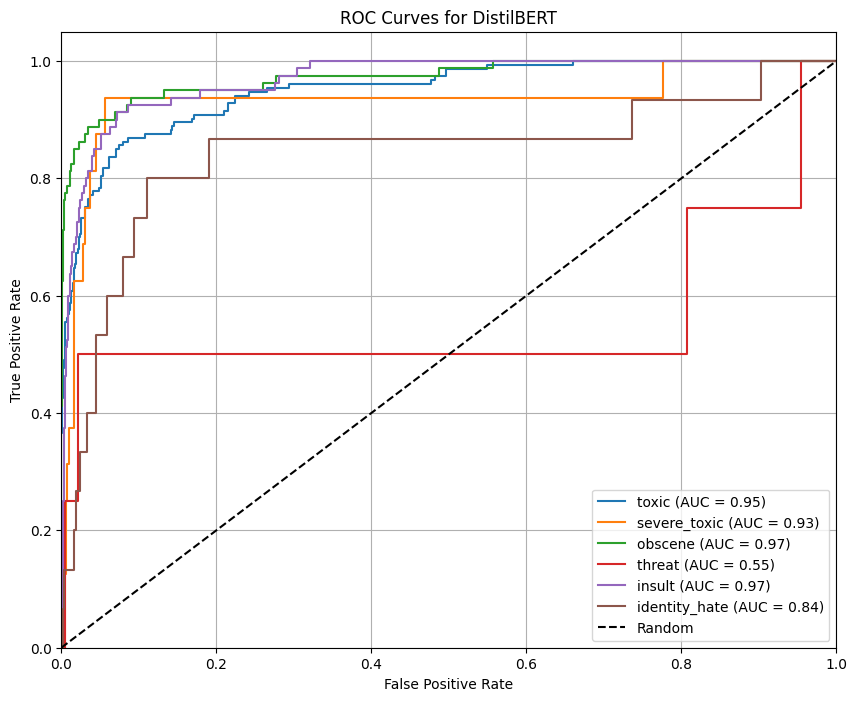

In [ ]:
# preds_distil = trainer1.predict(val_dataset1)
probs_distil = torch.sigmoid(torch.tensor(preds.predictions)).numpy()
plot_roc_curves(y_val, probs_distil, label_cols, model_name="DistilBERT")



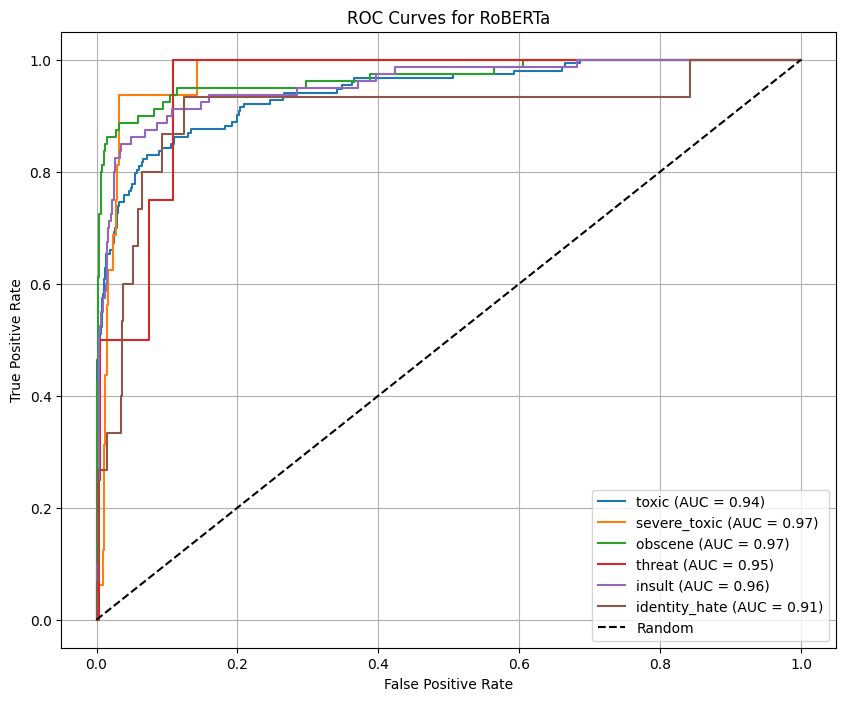

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Plot ROC curves
def plot_roc_curves(y_true, probs, class_names, model_name="RoBERTa"):
    plt.figure(figsize=(10, 8))
    for i in range(len(class_names)):
        fpr, tpr, _ = roc_curve(y_true[:, i], probs[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{class_names[i]} (AUC = {roc_auc:.2f})")

    plt.plot([0, 1], [0, 1], 'k--', label="Random")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curves for {model_name}')
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()

# Run the function
plot_roc_curves(y_true, probs, label_cols, model_name="RoBERTa")


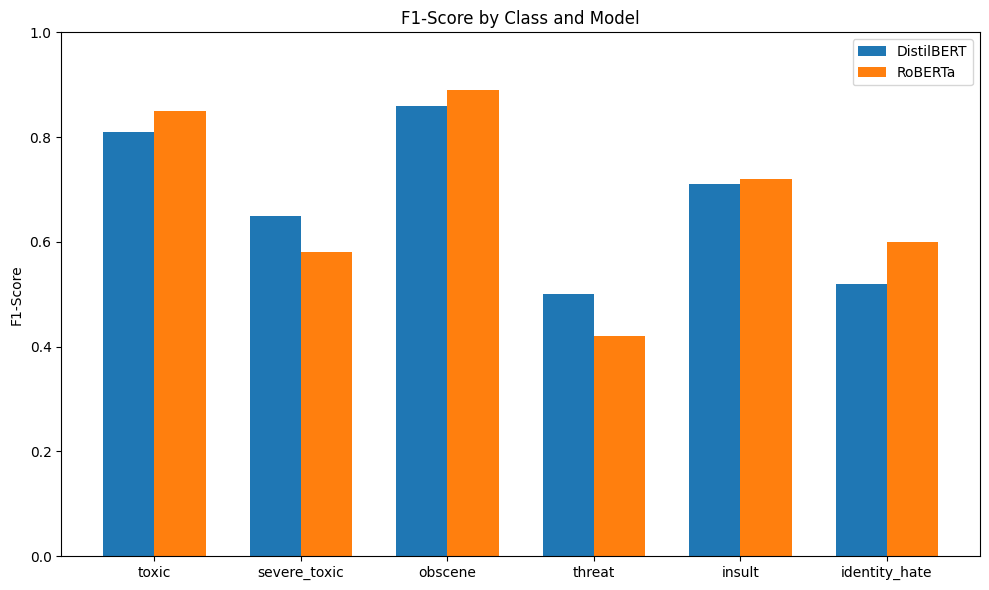

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# F1-scores for each class
f1_distil = [0.81, 0.65, 0.86, 0.50, 0.71, 0.52]    # DistilBERT
f1_roberta = [0.85, 0.58, 0.89, 0.42, 0.72, 0.60]   # RoBERTa

# Class names
classes = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

# Set up bar positions
x = np.arange(len(classes))
width = 0.35

# Create plot
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(x - width/2, f1_distil, width, label='DistilBERT')
ax.bar(x + width/2, f1_roberta, width, label='RoBERTa')

# Customize plot
ax.set_ylabel('F1-Score')
ax.set_title('F1-Score by Class and Model')
ax.set_xticks(x)
ax.set_xticklabels(classes)
ax.set_ylim(0, 1.0)
ax.legend()

plt.tight_layout()
plt.show()


### 🔍 Model Comparison: DistilBERT vs RoBERTa

The bar plot below compares the F1-scores of DistilBERT and RoBERTa across each class in the toxic comment classification task. This visualization provides insights into which model performs better for specific categories, such as `obscene`, `insult`, and `severe_toxic`, helping us identify the strengths and limitations of each model.
